# Model Audit Pipeline: Explainability
## Dataset: Prosper Loan Data

In this notebook, we apply explainability techniques to the previously trained models:
- Logistic Regression
- Random Forest
- XGBoost

Audits will include:
1. Global explainability (SHAP summary)
2. Local explainability (SHAP individual predictions)
3. Feature importance analysis


## Load data and models

In [1]:
import sys
import os

# Add the project root to the Python path
sys.path.append(os.path.abspath('..'))

from audit_tool import explainability as exp
import pandas as pd
import joblib

# Load train data
X_train = pd.read_csv('../data/processed/prosperloan/X_train_lasso.csv')
y_train = pd.read_csv('../data/processed/prosperloan/y_train_lasso.csv')
X_train_unscaled = pd.read_csv('../data/processed/prosperloan/X_train_unscaled.csv')
y_train_unscaled = pd.read_csv('../data/processed/prosperloan/y_train_unscaled.csv')

# Load test data
X_test = pd.read_csv('../data/processed/prosperloan/X_test_lasso.csv')
y_test = pd.read_csv('../data/processed/prosperloan/y_test_lasso.csv')
X_test_unscaled = pd.read_csv('../data/processed/prosperloan/X_test_unscaled.csv')
y_test_unscaled = pd.read_csv('../data/processed/prosperloan/y_test_unscaled.csv')

# Load models
log_model = joblib.load('../models/prosperloan/logisticregression.pkl')
rf_model = joblib.load('../models/prosperloan/randomforest.pkl')
xgb_model = joblib.load('../models/prosperloan/xgboost.pkl')

print("Data and models loaded successfully.")


Data and models loaded successfully.


## SHAP Global Explainability 
### XGBoost 

100%|===================| 22686/22788 [03:50<00:01]        

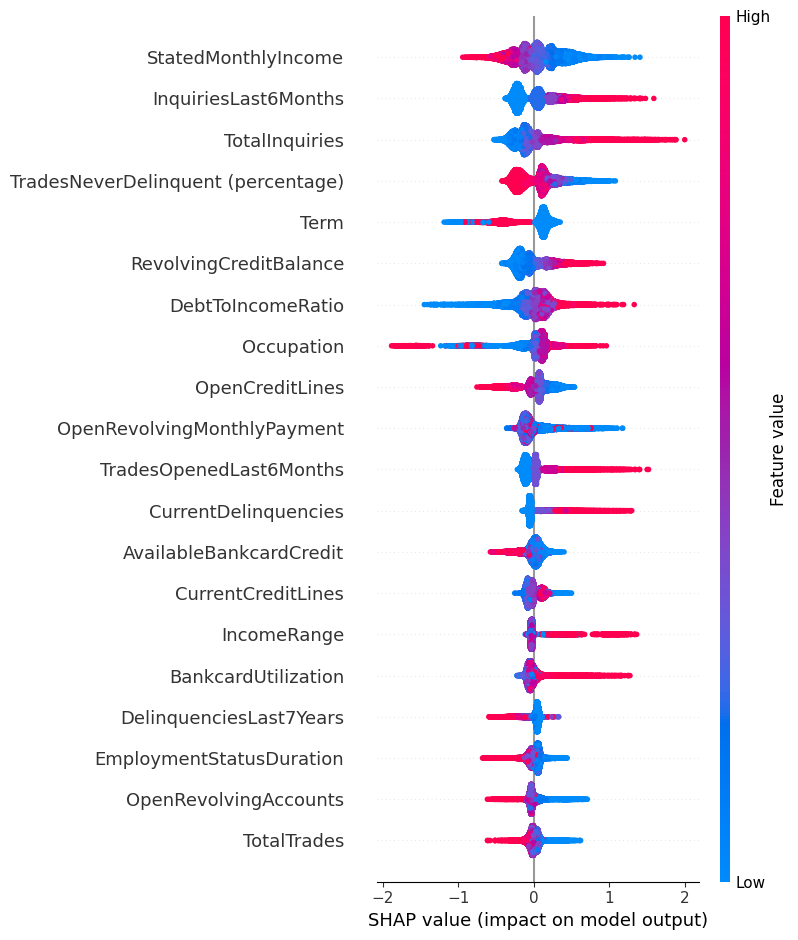

<Figure size 640x480 with 0 Axes>

In [2]:
# Compute SHAP values for XGBoost model
xgb_shap_values, X_used = exp.compute_shap_values(xgb_model, X_test)

# Summary plot (automatically detects binary classification)
exp.plot_shap_summary(xgb_shap_values, X_used, max_display=20)


### Logistic Regression

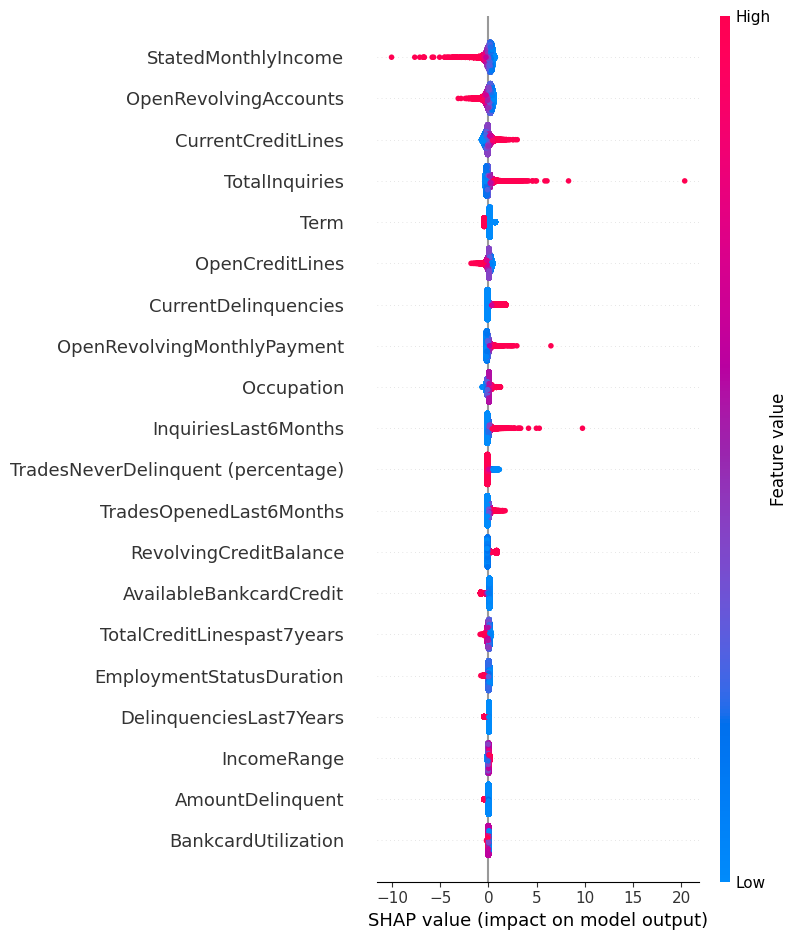

<Figure size 640x480 with 0 Axes>

In [3]:
# Compute SHAP values for Logistic Regression
log_shap_values, X_used = exp.compute_shap_values(log_model, X_test)

# Plot SHAP summary (using scaled features)
exp.plot_shap_summary(log_shap_values, X_used, max_display=20)


### Random Forest


In [4]:
# Sample from X_test for SHAP
X_sample = X_test.sample(100, random_state=42)

# Then compute SHAP
rf_shap_values, X_used = exp.compute_shap_values(rf_model, X_sample)

 99%|===================| 198/200 [00:32<00:00]        

<Figure size 640x480 with 0 Axes>

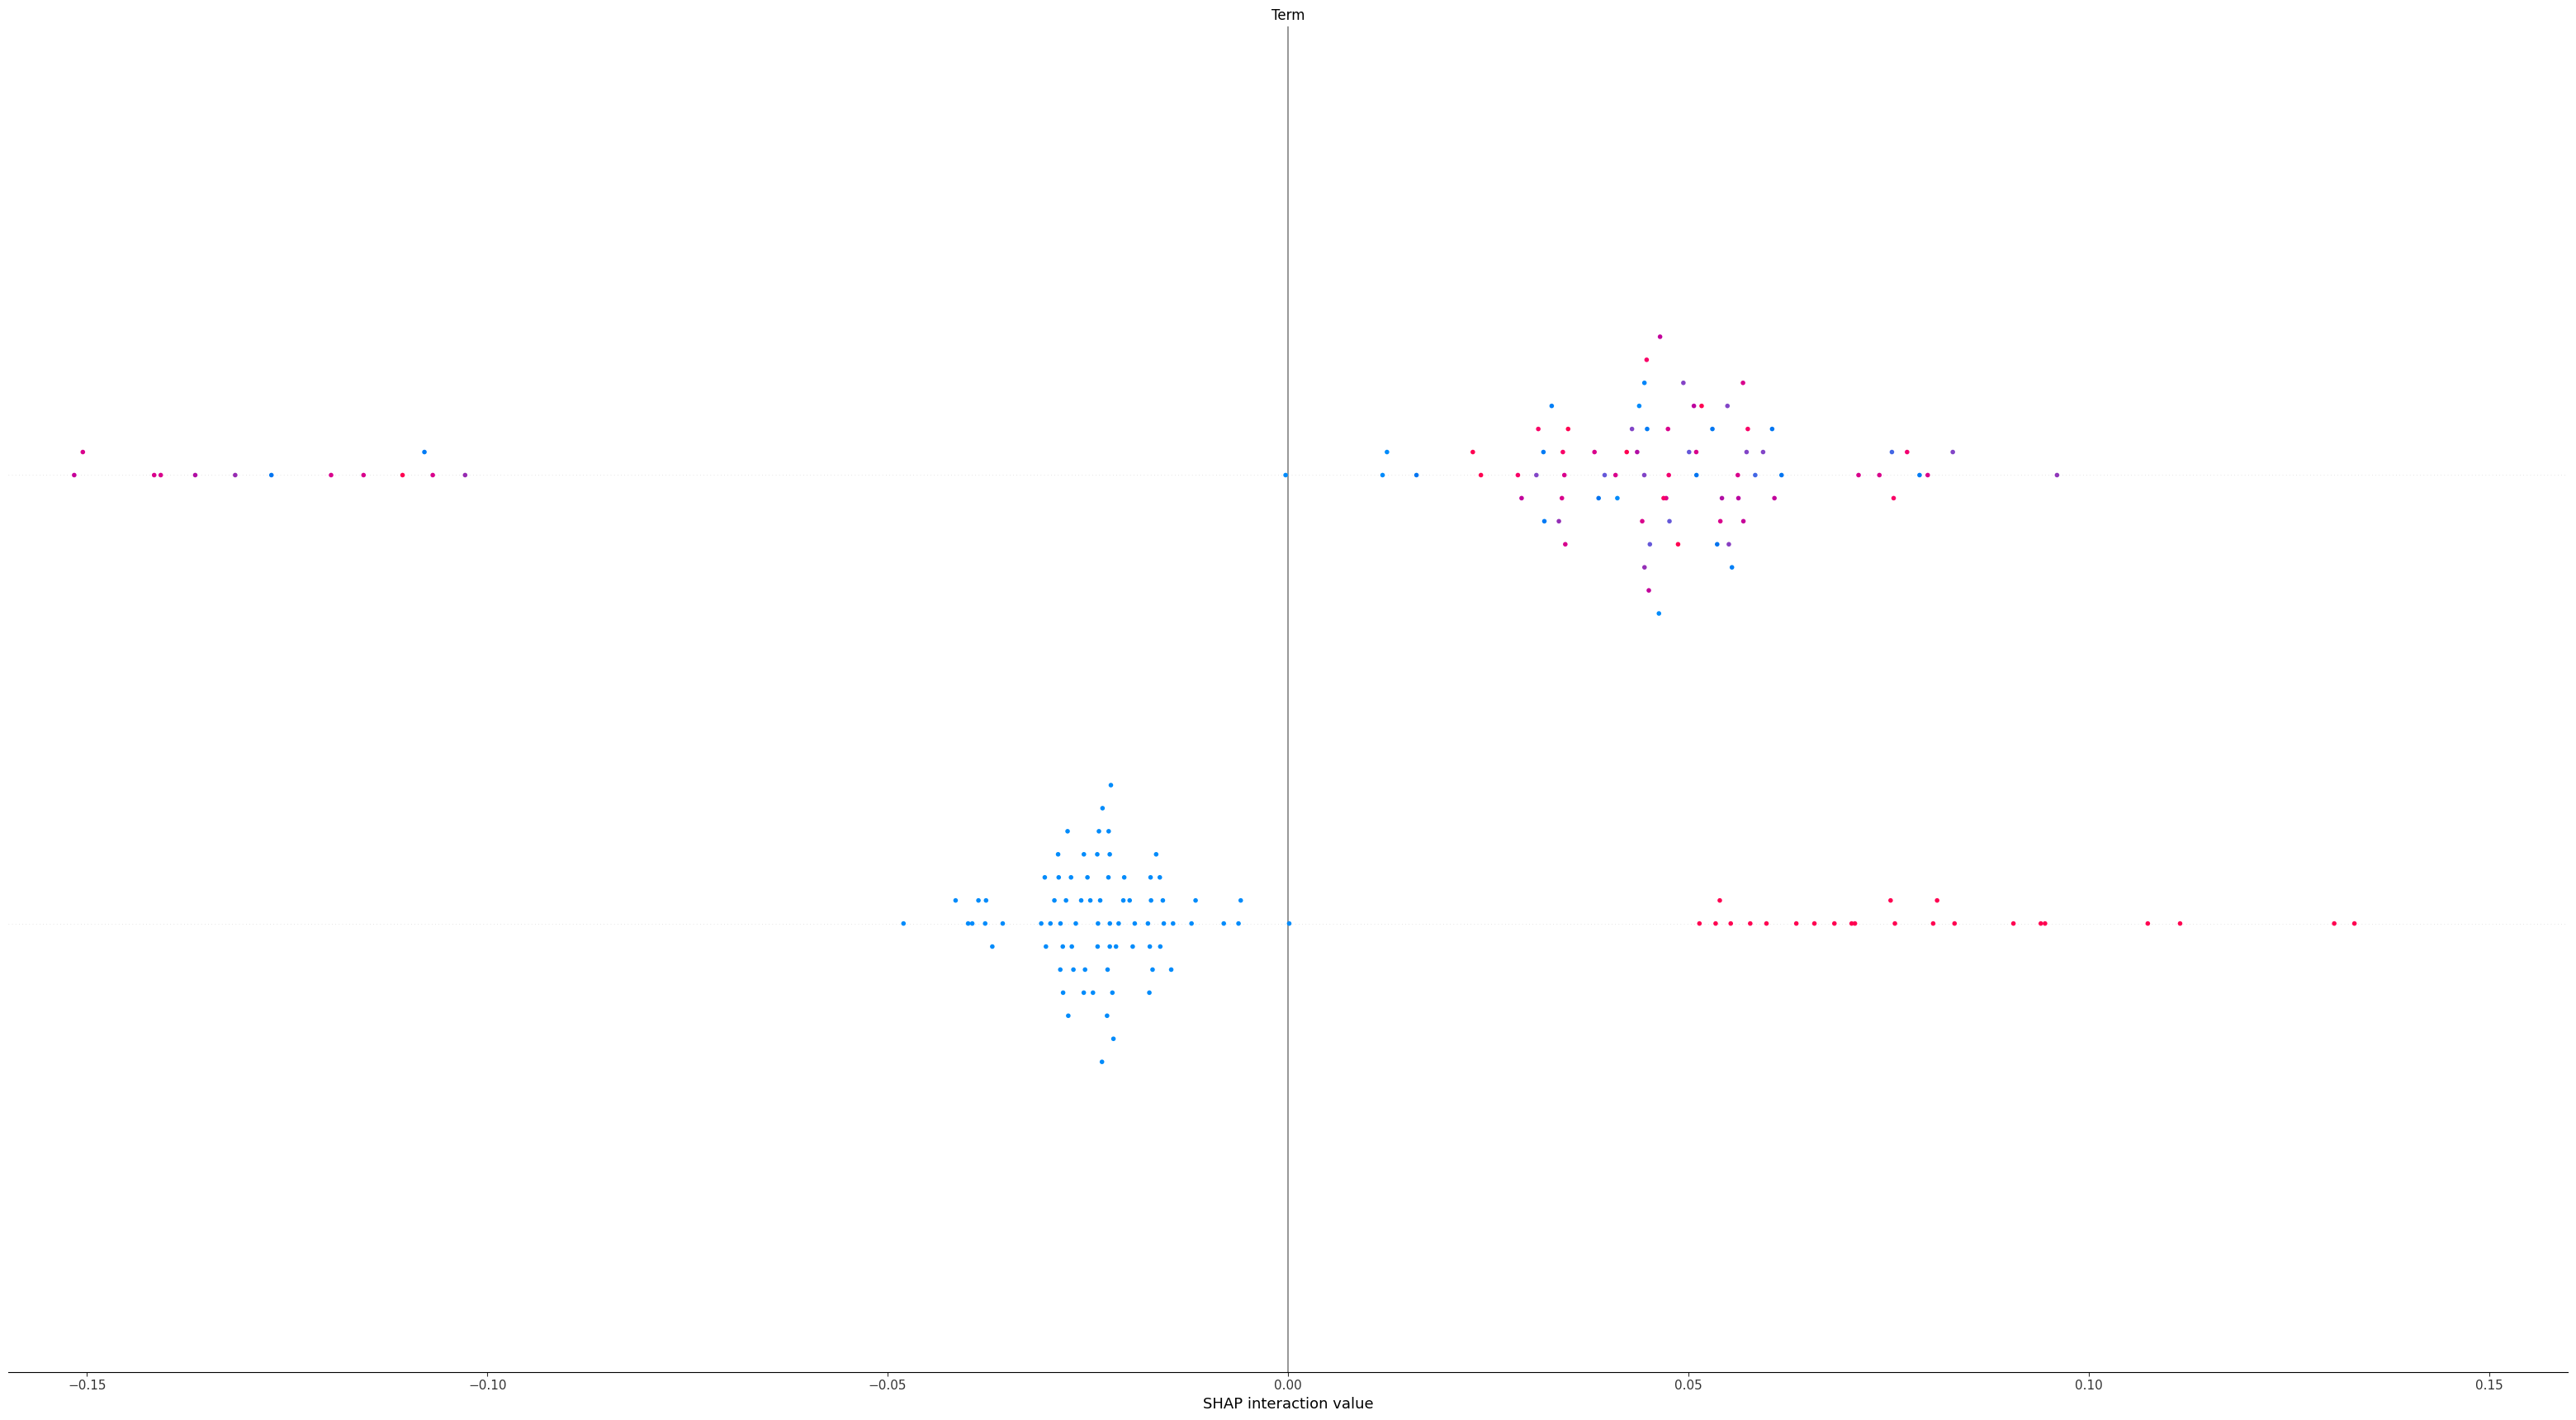

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot SHAP summary (auto-handles binary classification)
exp.plot_shap_summary(rf_shap_values, X_used, max_display=20)

### Feature Importances from Tree-Based Models

To complement the SHAP-based explainability analysis, we also review the built-in feature importances provided by tree-based models such as Random Forest and XGBoost.

Feature importances in these models are computed based on the contribution of each feature to the construction of decision trees. In the case of Random Forests, importances reflect the average reduction in Gini impurity across all trees where a feature is used. For XGBoost, several importance types are available (e.g., *gain*, *weight*, *cover*), with *gain* being the most commonly used as it represents the average improvement in performance brought by each feature.

Unlike SHAP, which measures the marginal contribution of each feature per prediction, these built-in metrics provide a global view of how much the model relies on each feature during training.

By comparing SHAP results with traditional feature importance scores, we can validate whether the model’s behavior is consistent from both a decision-tree and a prediction-contribution perspective.

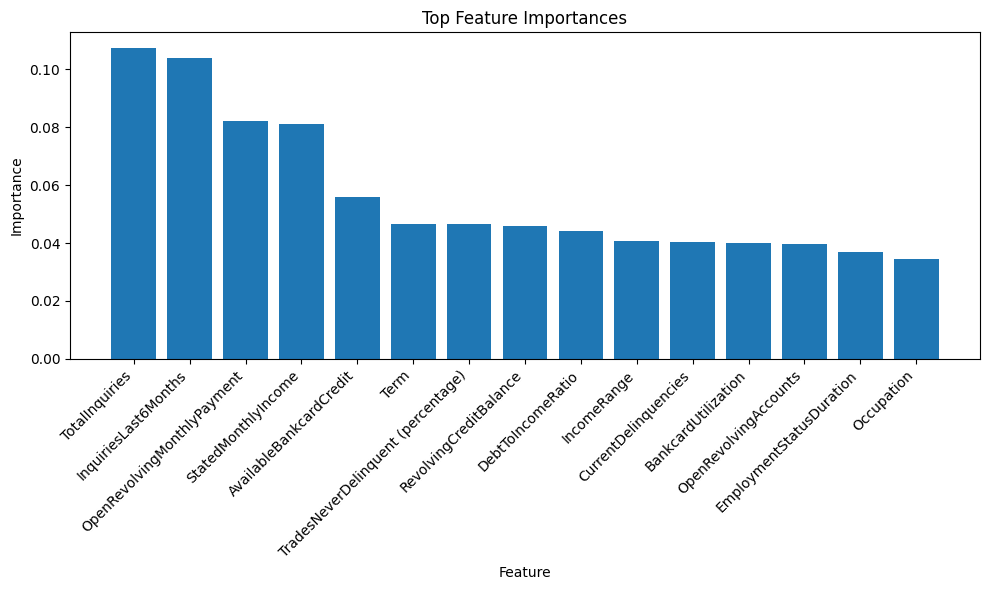

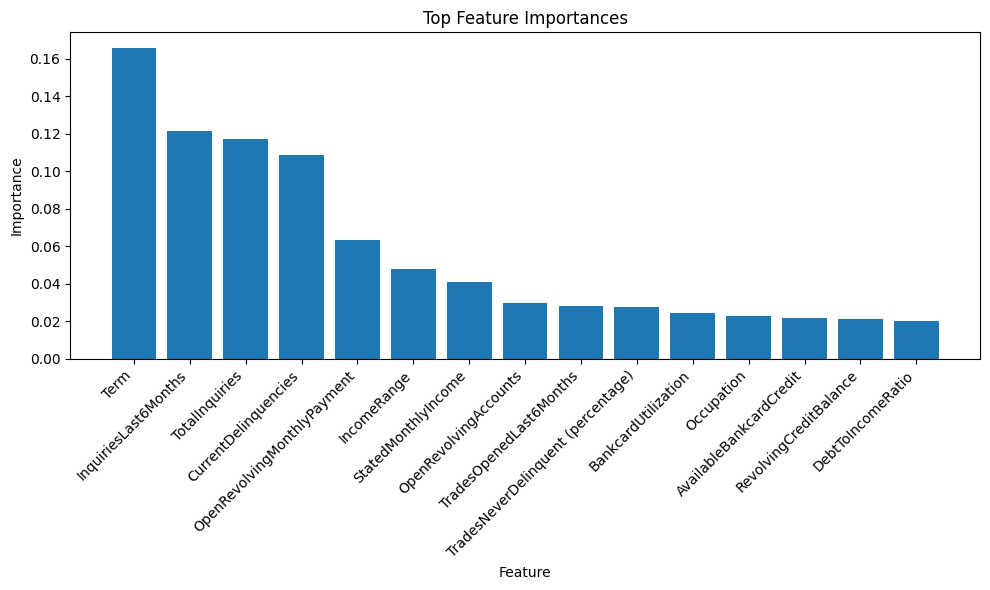

[INFO] Feature importances not available for this model type.


In [6]:
rf_importances_df = exp.plot_model_feature_importance(rf_model, X_test.columns, top_n=15)
xgb_importances_df = exp.plot_model_feature_importance(xgb_model, X_test.columns, top_n=15)
log_importances_df = exp.plot_model_feature_importance(log_model, X_test.columns)  # will print info and return None

Unlike tree-based models, Logistic Regression does not have a built-in feature importance attribute such as `.feature_importances_`. Instead, it provides model coefficients that reflect the weight of each feature in the linear decision function.

While these coefficients can indicate the direction and magnitude of a feature's effect (positive or negative), they are sensitive to feature scaling and multicollinearity, and do not reflect the actual contribution of a feature to individual predictions.

To address this, we rely on SHAP values, which provide a consistent, model-agnostic way to assess the local and global impact of features — even in linear models like Logistic Regression.

## Local Explainability: SHAP Waterfall

To understand the model's decision for individual cases, we use SHAP waterfall plots. These plots allow us to visualize how each feature pushes the prediction from the base value (expected prediction) toward the final model output for a specific instance.

This form of local explanation is particularly useful for validating individual decisions, such as why a particular applicant was classified as high or low credit risk.

We will now plot the SHAP values for a selected instance from the test set.

### XGBoost

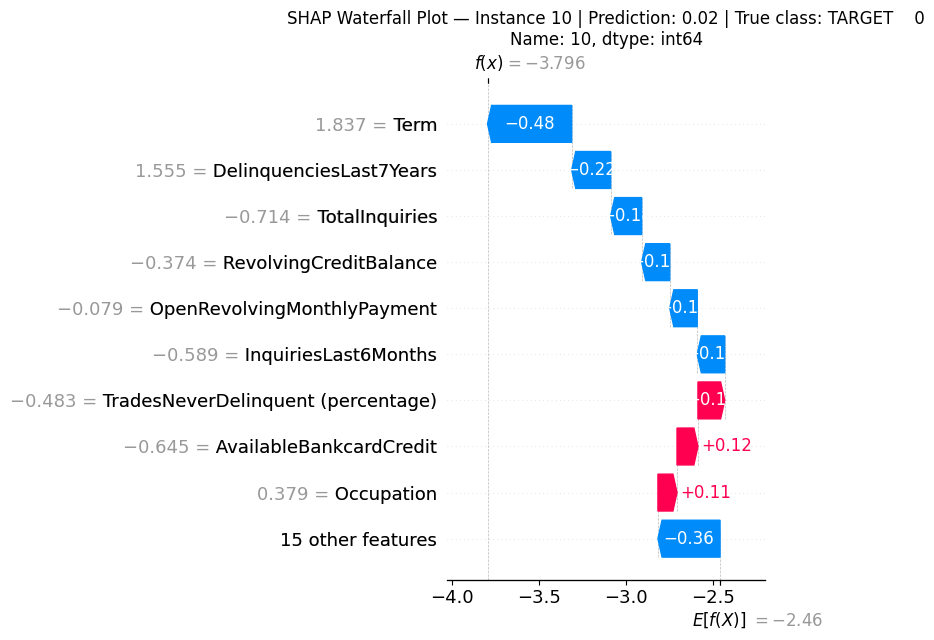

In [7]:
# Plot SHAP waterfall for class 1 (positive class)
exp.plot_shap_waterfall(xgb_shap_values, instance_idx=10, model=xgb_model, X=X_test, y_true=y_test)


### Logistic Regression

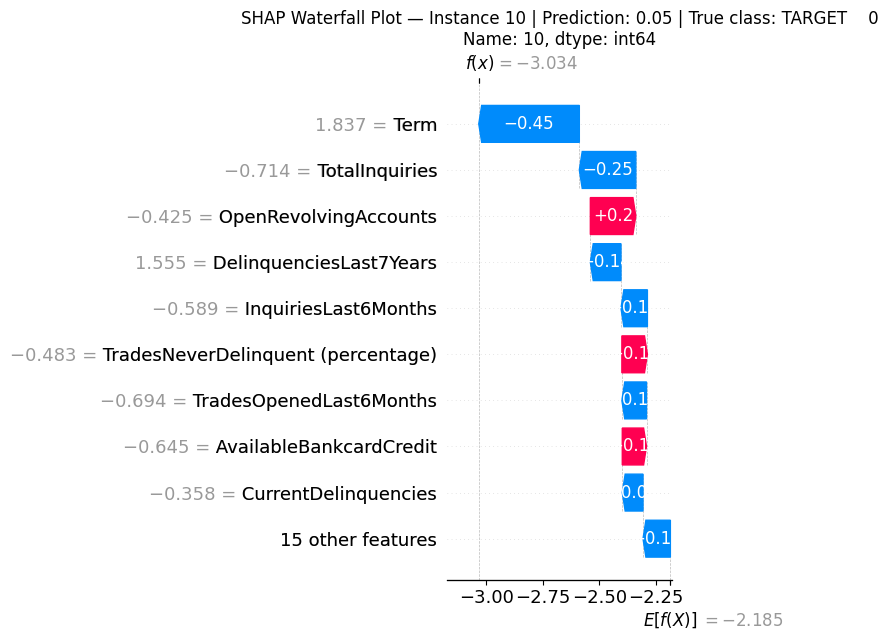

In [8]:
# Plot waterfall (logistic regression outputs array, not list)
exp.plot_shap_waterfall(log_shap_values, instance_idx=10, model=log_model, X=X_test, y_true=y_test)

### Random Forest

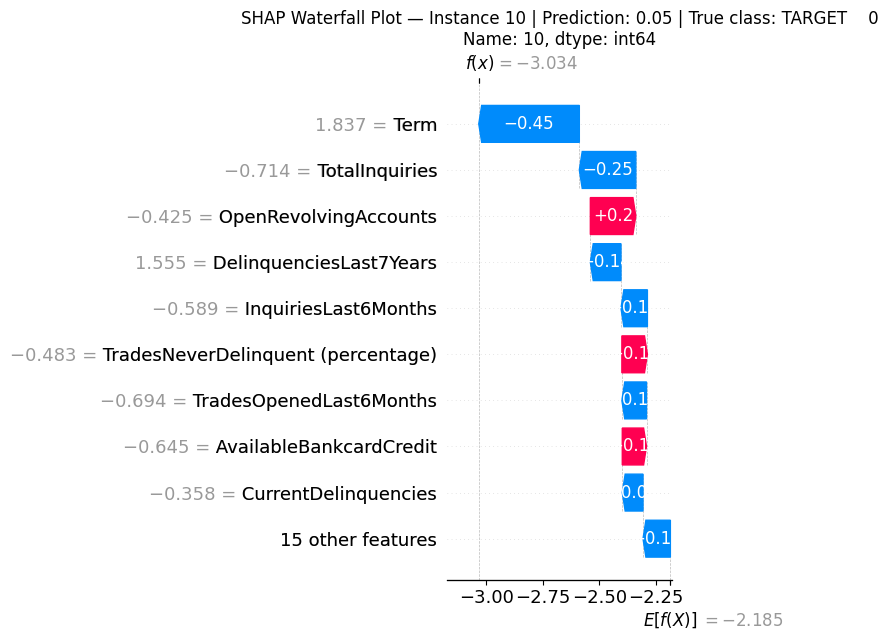

In [9]:
# Plot waterfall (select class 1 for binary classification)
exp.plot_shap_waterfall(log_shap_values, instance_idx=10, model=log_model, X=X_test, y_true=y_test)

## Local Explainability with LIME

We will now prepare the LIME explainer to interpret individual predictions.

### XGBoost

In [10]:
exp.explain_instance_lime(
    model=xgb_model,
    X=X_test,
    instance_idx=10,
    y_true=y_test
)

LIME Explanation for instance 10
Model prediction (P=Default): 0.02
True label: 0 (Non-Default)


### Logistic Regression

In [11]:
exp.explain_instance_lime(
    model=log_model,
    X=X_test,
    instance_idx=10,
    y_true=y_test
)


LIME Explanation for instance 10
Model prediction (P=Default): 0.05
True label: 0 (Non-Default)


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Random Forest

In [12]:
exp.explain_instance_lime(
    model=rf_model,
    X=X_test,
    instance_idx=10,
    y_true=y_test
)


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME Explanation for instance 10
Model prediction (P=Default): 0.11
True label: 0 (Non-Default)


## Summary

We successfully applied SHAP and LIME to explain model predictions globally and locally for all three models:
- Logistic Regression
- Random Forest
- XGBoost

Next step: generalize this process into an audit pipeline that can automatically perform these steps given any model and dataset.
